# Fine-tuning InceptionV3 for food nutrition classifier

In [35]:
import tensorflow as tf
#suppress "INFO:tensorflow:Summary name .... is illegal; using ... instead." warnings.
tf.logging.set_verbosity(tf.logging.WARN)

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from download import download_file
import os.path
import numpy as np

### Database parameters

In [60]:
# Set metadata database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/data.sqlite', 'data.sqlite')
database_path = 'data.sqlite'

# Set image database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/image_data_299.sqlite', 'image_data_299.sqlite')
image_data_database_path = 'image_data_299.sqlite'

# Index cache
condition_indeces = None

#Set the id of classification stored in the database which will be used to train model.
classification_id = 6 #11

File already downloaded (size: 174744576)
File already downloaded (size: 7500314624)


### Training parameters

In [61]:
# Limit number of images used for training and testing.
train_max = 1000000
val_max = 1000000
test_max = 1000

# Image dimensions (Inception input size)
img_width, img_height = 299, 299

# Set batch size to biggest that fits in your memory.
batch_size = 256

# Number of epochs to train top inception network blocks.
top_epochs = 3

# Number of epochs to fine tune the network.
fit_epochs = 3

### Name the run

In [62]:
# Name the current parameters set. This name will be used as a Tensorboard log directory subfolder.
# having separate subfolder for each run will allow you to conviniently view performance changes beween runs.

run_name = "cid%d_tm%d_vm%d_bs%d_te%d_te%d" % (classification_id, 
                                               train_max, val_max, 
                                               batch_size, top_epochs, 
                                               fit_epochs)

print ("Run name: %s" % run_name)

Run name: cid6_tm1000000_vm1000000_bs256_te3_te3


### Initializing 

In [63]:
# Import custom SQLite data reader
from sqlite_data_loader import SQLiteDataLoader

sdl = SQLiteDataLoader(database_path, image_data_database_path)

# Load the number of nutrition classes
class_count = len(sdl.get_condition_indeces(classification_id))

print ("Number of nutrition classes: %d" % class_count)

Number of nutrition classes: 25


In [64]:
# Get the number of train and validation samples
nb_train_samples = 0
train_pr = 0.7
nb_validation_samples = 0
valid_pr = 0.25
nb_test_samples = 0
test_pr = 0.05

for ci in sdl.get_condition_indeces(classification_id):
    nb_train_samples += sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max)
    nb_validation_samples += sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max)
    nb_test_samples += sdl.get_image_count_by_condition_index(ci, classification_id, test_pr, val_max)

print ("Train samples: %d" % nb_train_samples)
print ("Validation samples: %d" % nb_validation_samples)
print ("Test samples: %d" % nb_validation_samples)

Class 0 has 31749 images.
Class 1 has 12121 images.
Class 2 has 14990 images.
Class 3 has 17457 images.
Class 4 has 15333 images.
Class 5 has 2780 images.
Class 6 has 11137 images.
Class 7 has 10725 images.
Class 8 has 5003 images.
Class 9 has 16128 images.
Class 10 has 6185 images.
Class 11 has 20326 images.
Class 12 has 7028 images.
Class 13 has 43165 images.
Class 14 has 6547 images.
Class 15 has 19614 images.
Class 16 has 56190 images.
Class 17 has 11302 images.
Class 18 has 9167 images.
Class 19 has 15483 images.
Class 20 has 18152 images.
Class 21 has 23381 images.
Class 22 has 14713 images.
Class 23 has 7784 images.
Class 24 has 9524 images.
Train samples: 284176
Validation samples: 101488
Test samples: 101488


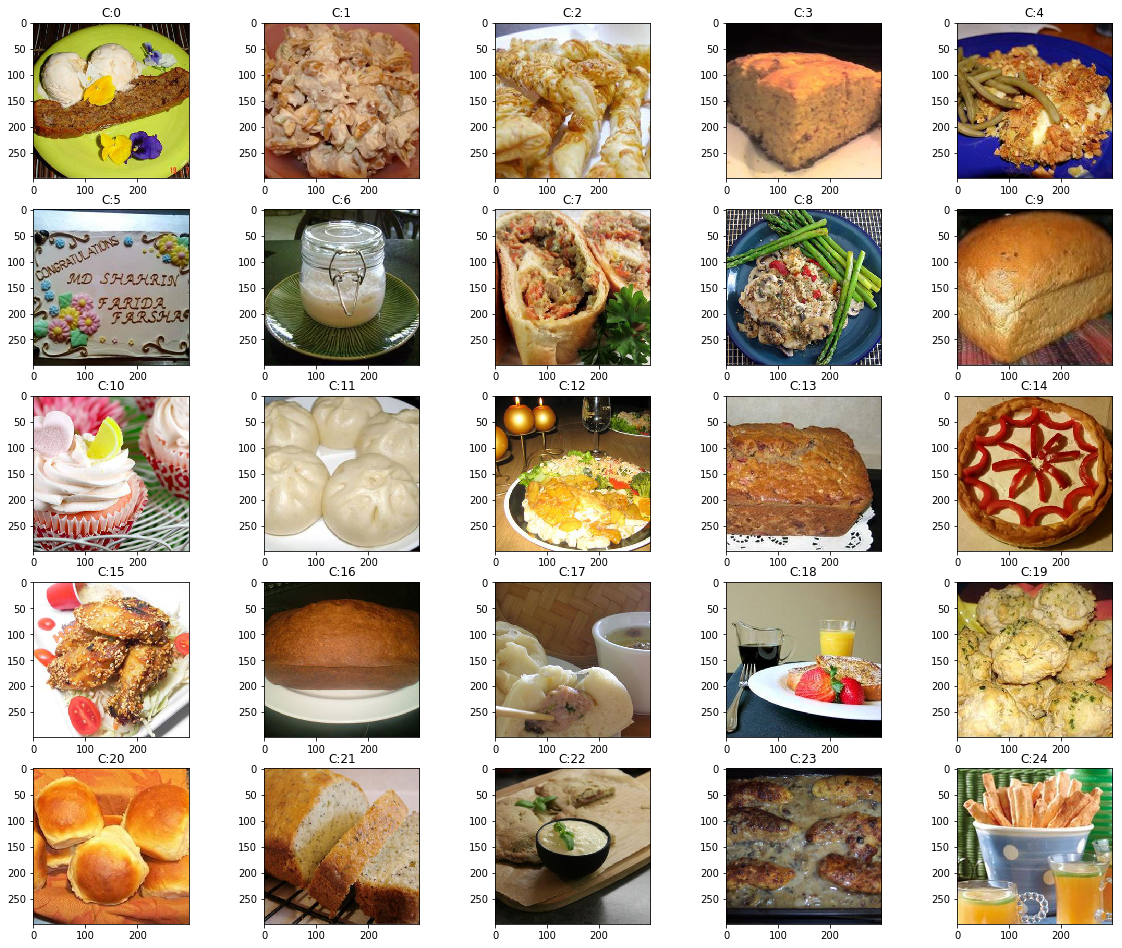

In [65]:
"""
Show an image for each nutrition class. 
"""

from image_ex import load_img_bytes
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
columns = 5

for ci in range(class_count):
    image_id = sdl.get_image_ids_by_condition_index(ci, classification_id, 0, 1)[0]
    image_data = sdl.get_image_data_by_id(image_id)
    pil_img = load_img_bytes(image_data)
    
    sp = fig.add_subplot(class_count / columns + 1, columns, ci + 1)
    sp.set_title('C:%d'%ci)
    plt.imshow(pil_img)
    

## Visualize recipe classification

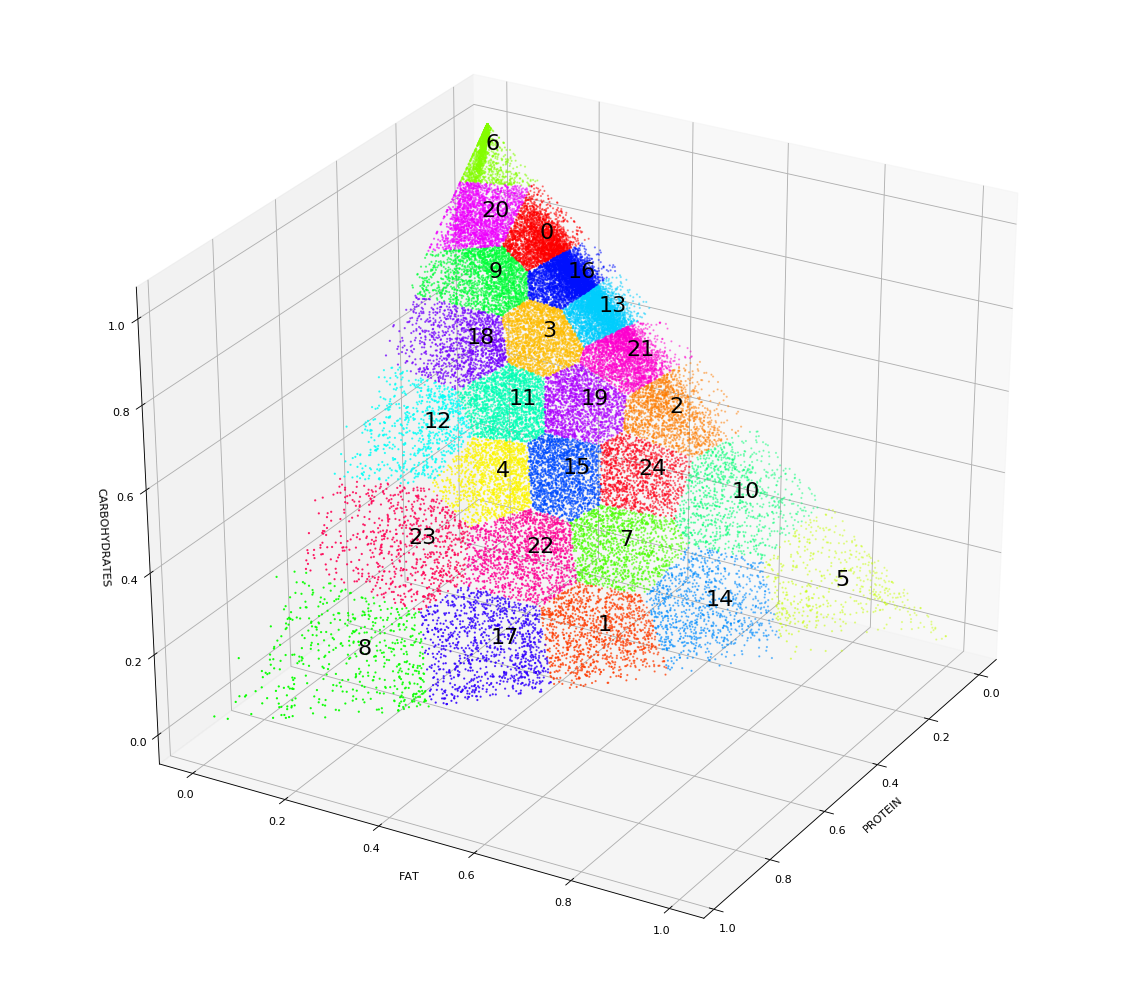

In [66]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.axes(projection='3d')

ax.view_init(30, 30)

rates = np.array(sdl.get_nutrition_values(classification_id))

# Data for three-dimensional scattered points
rates_x = rates[:,0]
rates_y = rates[:,1]
rates_z = rates[:,2]

rates_c = rates[:,3]
rates_c /= class_count

ax.scatter3D(rates_x, rates_y, rates_z, c=rates_c, cmap='hsv', s=1);

ax.set_xlabel('PROTEIN')
ax.set_ylabel('FAT')
ax.set_zlabel('CARBOHYDRATES')

centroids = np.array(sdl.get_centroids(classification_id)) 

for cd in centroids:
    ax.text(cd[0],cd[1],cd[2],  '%d' % cd[3], size=20, zorder=1, color='k') 

## Building the model

In [74]:
# Set checkpoint save files
top_layers_checkpoint_path = 'cp.top.%s.hdf5' % run_name
fine_tuned_checkpoint_path = 'cp.ftuned.%s.hdf5' % run_name
new_extended_inception_weights = 'weights.%s.hdf5' % run_name

print ("Top layer train checkpoint: %s" % top_layers_checkpoint_path)
print ("Fine tune checkpoint: %s" % fine_tuned_checkpoint_path)
print ("Final weights: %s" % new_extended_inception_weights)

Top layer train checkpoint: cp.top.cid6_tm1000000_vm1000000_bs256_te3_te3.hdf5
Fine tune checkpoint: cp.ftuned.cid6_tm1000000_vm1000000_bs256_te3_te3.hdf5
Final weights: weights.cid6_tm1000000_vm1000000_bs256_te3_te3.hdf5


In [68]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer    # ADDED BY ME
x = Dense(1024, activation='relu')(x)  # ADDED BY ME
# let's add a dropout regularization   # ADDED BY ME
x = Dropout(0.4)(x)                    # ADDED BY ME
# let's add a second fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 125 classes
predictions = Dense(class_count, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], )

/home/aind2/anaconda3/envs/recipes/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Checkpoint 'cp.top.best.3.hdf5' loaded.


### Setup data generators

In [69]:
# Import custom image data generator capable of taking lamda function to load data from SQLite 
from image_ex import ImageDataGeneratorEx

# prepare data augmentation configuration
train_datagen = ImageDataGeneratorEx(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGeneratorEx(rescale=1. / 255)

train_generator = train_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, 0, sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max), sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    batch_size=batch_size,
    class_mode='categorical')

Found 284176 images belonging to 25 classes.
Found 101488 images belonging to 25 classes.


In [70]:
#Save the model after every epoch.
mc_top = ModelCheckpoint(top_layers_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#Save the TensorBoard logs.
tb = TensorBoard(log_dir=('./logs/%s'%run_name), histogram_freq=1, write_graph=True, write_images=True)

In [71]:
# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=top_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_top, tb])

Epoch 1/3
 448/1110 [===========>..................] - ETA: 2040s - loss: 2.7282 - acc: 0.1753

KeyboardInterrupt: 

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [ ]:
# Save the model after every epoch.
mc_fit = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Load saved wights
if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print ("Checkpoint '" + fine_tuned_checkpoint_path + "' loaded.")


In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#model.fit_generator(...)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=fit_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_fit, tb])

model.save_weights(new_extended_inception_weights)

In [ ]:
#model.load_weights(new_extended_inception_weights)
'''
CHANGE AS NEEDED

nutrition_class_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
'''